# Проект - Стримчик

### Описание проекта

Магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Последовательность выполнения проекта

* Загрузка данных, их изучение и подготовка к дальнейшему анализу
* Проведение исследовательского анализа данных (количество выпущенных игр по годам, продажи по платформам, влияние отзывов и критиков на продажи игр, выделение самых прибыльных жанров)
* Составление портретов пользователей каждого региона (самые популярные платформы и жанры, влияние рейтинга ESRB на продажи)
* Проверка гипотез (1 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые, 2 - средние пользовательские рейтинги жанров Action и Sports разные)
* Формулировка основных выводов и рекомендация по проекту

### Описание данных

* `Name` — название игры

* `Platform` — платформа

* `Year_of_Release` — год выпуска

* `Genre` — жанр игры

* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)

* `EU_sales` — продажи в Европе (миллионы проданных копий)

* `JP_sales` — продажи в Японии (миллионы проданных копий)

* `Other_sales` — продажи в других странах (миллионы проданных копий)

* `Critic_Score` — оценка критиков (максимум 100)

* `User_Score` — оценка пользователей (максимум 10)

* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Загрузка данных и подготовка их к анализу

### Загрузка и обзор данных

In [1]:
#Импорт библиотек
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display
import warnings
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import stats as st


# отключение уведомлений об ошибке при замене исходного набора данных
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# показ всех колонок датафрейма
pd.options.display.max_columns = None

In [2]:
# загружаем файл в переменную и выводим на экран первые 5 строк
games = pd.read_csv('D:/Datasets/games.csv')

games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Посмотрим данные подробнее

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Выводы**

В данных присутствуют пропуски, больше всего их в колонках `Critic_Score`, `User_Score`, `Rating`. Так же в некоторых колонках нужно будет поменять тип данных и привести их названия к нижнему регистру.

### Предобработка данных

#### Приведение колонок к нижнему регистру

In [4]:
games.columns = games.columns.str.lower()

In [5]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Добавление столбца общих продаж

In [6]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

#### Обработка пропусков

Заменим пропуски значений в столбцах `critic_score` и `user_score` заглушками (-1), в дальнейшем в исследовании будем их фильтровать. Непроставленные оценки (tbd) так же заменим на (-1)

In [7]:
games['critic_score'] = games['critic_score'].fillna(-1)

games['user_score'] = games['user_score'].fillna(-1)
games['user_score'] = games['user_score'].replace('tbd','-1').astype('float')

Поставим заглушки так же для столбца `rating`

In [8]:
games['rating'] = games['rating'].fillna('None')

In [9]:
games['rating'].value_counts()

None    6766
E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

Остальные пропуски выбросим из таблицы, т.к. их остаётся незначительное количество

In [10]:
games.isna().sum()

name                 2
platform             0
year_of_release    269
genre                2
na_sales             0
eu_sales             0
jp_sales             0
other_sales          0
critic_score         0
user_score           0
rating               0
total_sales          0
dtype: int64

In [11]:
games = games.dropna()

games['year_of_release'] = games['year_of_release'].astype('int')

#### Обработка дубликатов

In [12]:
games = games.drop_duplicates()

**Выводы**

Данные успешно предобработаны 😎

## Исследовательский анализ данных

### Выпуск игр по годам

In [13]:
games_by_year = (games.groupby('year_of_release', as_index=False)['name'].count()
                 .rename(columns={'name':'games_cnt'}))

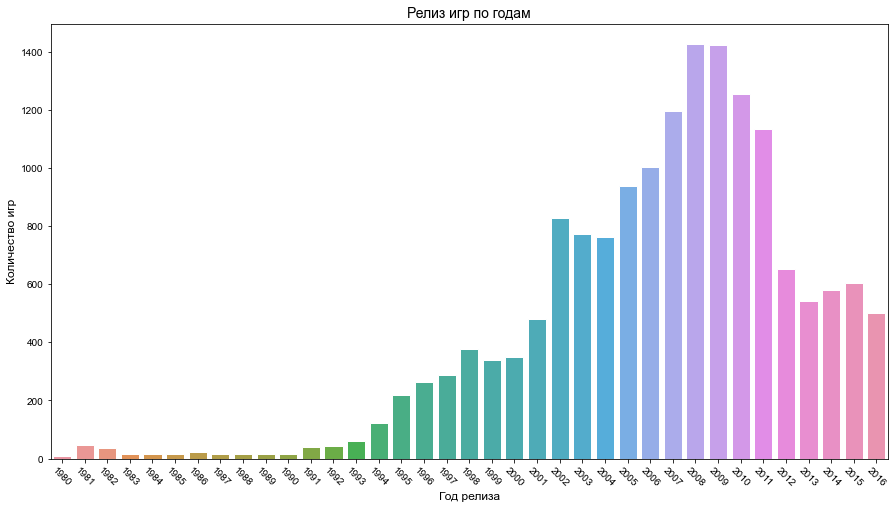

In [14]:
fig, ax = plt.subplots(figsize=(15,8))
sns.set(font_scale = 1.1)
sns.set_style("darkgrid")
plt.xticks(rotation=-45)

sns.barplot(data=games_by_year, x='year_of_release', y='games_cnt', ax=ax)
ax.set_xlabel('Год релиза', fontsize = 12)
ax.set_ylabel('Количество игр', fontsize = 12)
ax.set_title('Релиз игр по годам', fontsize = 14)


plt.show()

In [15]:
games_by_year

,year_of_release,games_cnt
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


**Выводы**

Больше всего вышло игр в 2008 (1427) и 2009 (1426), меньше всего в 1980 (всего 9), но такое малое количество релизов может быть связано с неполнотой данных. Если говорить об играх, выходящих на новом поколении консолей (c 2012 года), то всего вышло 2886 игр для новых консолей и ПК. Стоит анализировать данный промежуток времени, так как он наиболее актуален при планировании продаж игр на ближайшие годы.

### Продажи по платформам

Рассмотрим продажи игр на 4-х поколениях консолей PlayStation, 3-х поколениях XBOX, двух поколениях консолей Nintendo, а также PC. То есть мы рассмотрим несколько поколений настольных консолей и пк. 

In [16]:
games_new = games.query('platform == ["PS2", "PS3", "X360", "PS", "Wii", "XB", "PS4", "XOne", "WiiU", "PC"]')

yearly_sales_platforms = games_new .groupby(['platform', 'year_of_release'], as_index=False)['total_sales'].sum()
yearly_sales_platforms = (yearly_sales_platforms.query('year_of_release > 1994'))

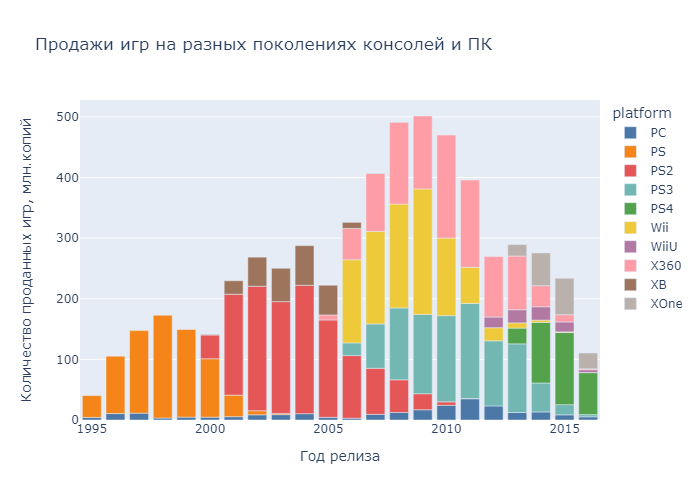

In [17]:
import plotly.express as px

fig = px.bar(yearly_sales_platforms, x="year_of_release", y='total_sales', color = 'platform', 
             title="Продажи игр на разных поколениях консолей и ПК",
             color_discrete_sequence=px.colors.qualitative.T10)

fig.update_xaxes(title_text='Год релиза')
fig.update_yaxes(title_text='Количество проданных игр, млн.копий')

fig.show("png")

In [18]:
yearly_sales_platforms.groupby('platform')['total_sales'].sum()

platform
PC       239.79
PS       721.55
PS2     1233.56
PS3      931.34
PS4      314.14
Wii      891.18
WiiU      82.19
X360     961.24
XB       251.57
XOne     159.32
Name: total_sales, dtype: float64

**Выводы**

* Жизненный цикл консолей составляет от 4 до 8 лет
* `Playstation` стабильно обгоняет `XBOX` и `Nintendo` по продажам игр
* Больше всего было продано игр на консоли `PS2` (1234 млн.копий), `X360` (961 млн.копий) и `PS3` (931 млн.копий)
* Продажи игр на PC стабильно отстают от продаж игр на консолях Microsoft и Sony

### Продажи игр на последнем поколении консолей

Для прогноза продаж игр на 2017 год будем рассматривать только актуальный период, то есть мы будем рассматривать продажи игр с 2012 года (год выхода первой консоли нового поколения WiiU).

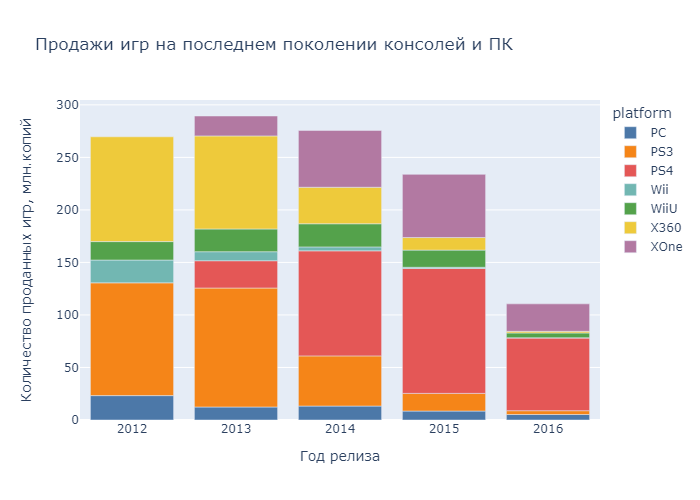

In [19]:
yearly_sales_new_platforms = yearly_sales_platforms.query('year_of_release > 2011')

import plotly.express as px

fig = px.bar(yearly_sales_new_platforms, x="year_of_release", y='total_sales', color = 'platform', 
             title="Продажи игр на последнем поколении консолей и ПК",
             color_discrete_sequence=px.colors.qualitative.T10)

fig.update_xaxes(title_text='Год релиза')
fig.update_yaxes(title_text='Количество проданных игр, млн.копий')

fig.show("png")

**Выводы**

* Больше всего игр было продано на консоли PS4 (314 млн.копий) и PS3 (288 млн.копий), затем идут X360 (233 млн.копий) и XOne (159 млн.копий), WiiU (82 млн.копий) и PC (56 млн.копий)
* Максимум продаж на консолях был в 2013 году (289 млн.копий), затем они стабильно снижались, дойдя до уровня продаж в 110 млн.копий в 2016 году. Возможно это связано с неполнотой данных за 2016 год.
* По графикам очень заметно, как происходил переходный период на консолях. Сначала новые консоли (PS4, XOne и WiiU) отхватывают часть сегмента продаж в 2012 - 2013 году, а дальше их доля на рынке всё растёт и игры на консоли прошлого поколения продаются всё меньшими тиражами.
* С 2012 по 2016 больше всего игр на ПК было продано в 2012 год (23 млн.копий)

### Ящик с усами для игр с разбивкой по платформам за актуальный период

Построим график "ящик с усами" для игр с разбивкой по платформам за актуальный период.

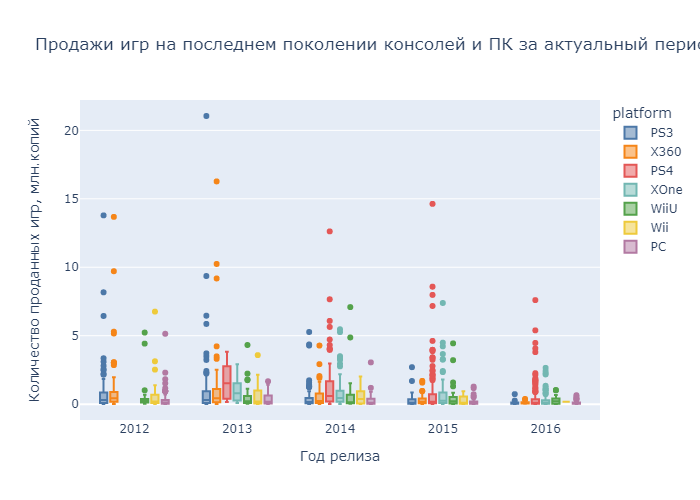

In [20]:
games_new = games_new.query('year_of_release > 2011')

fig = px.box(games_new, x="year_of_release", y='total_sales', color = 'platform', 
             title="Продажи игр на последнем поколении консолей и ПК за актуальный период",
             color_discrete_sequence=px.colors.qualitative.T10)

fig.update_xaxes(title_text='Год релиза')
fig.update_yaxes(title_text='Количество проданных игр, млн.копий')

fig.show("png")

Теперь те же графики, только установим верхнюю границу для проданных игр, так будет лучше виден масштаб

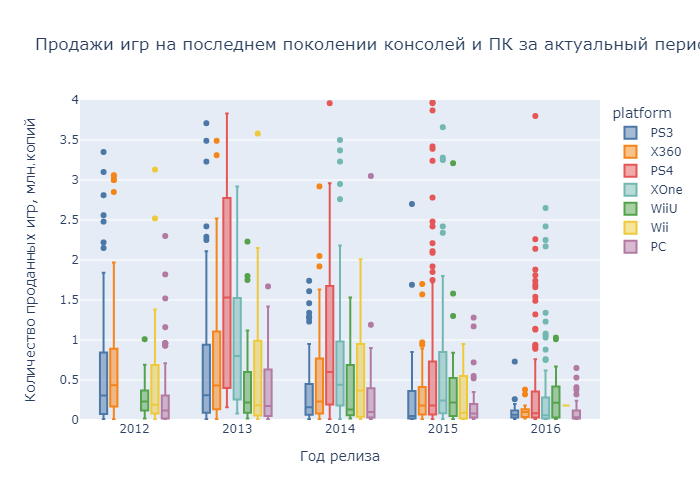

In [21]:
fig = px.box(games_new, x="year_of_release", y='total_sales', color = 'platform', 
             title="Продажи игр на последнем поколении консолей и ПК за актуальный период",
             color_discrete_sequence=px.colors.qualitative.T10)

fig.update_xaxes(title_text='Год релиза')
fig.update_yaxes(title_text='Количество проданных игр, млн.копий', range=[0, 4], row=1, col=1)


fig.show("png")

**Выводы**
* Если говорить об аномально высоких продажах игр, то в большинстве случаев они были на консолях X360, PS3, а затем и на PS4, в меньшей степени на WiiU и XOne. 
* По графиком так же очень заметно, насколько PS4 обходит другие платформы по продажам. Так же видно, что пик продаж игр на всех платформах был в 2013 году. 
* Продажи игр на PC значительно уступают продажам на консолях нового поколения, абсолютный лидер по продажам из консолей - это PS4, за ней из новых консолей идут XONE и Wii (продажи более новой WiiU остают от Wii). 
* Если смотреть на старые консоли от Microsoft, Sony и Nintendo, то продажи игр на X360 в среднем выше, чем на PS3 и Wii до 2014 года. Затем продажи игр с 2014 года на консолях PS3 и X360 начали снижаться, в то же время продажи игр на Wii были на пике в 2013-2014 годах. 

### Влияние отзывов критиков и пользователей на продажи игр 

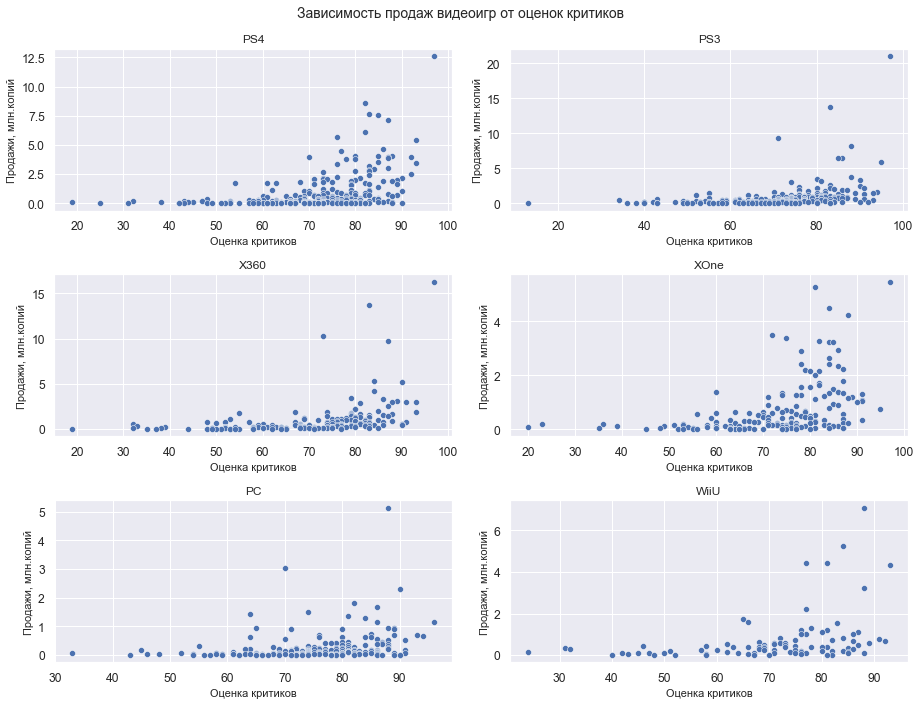

In [22]:
platforms = ['PS4', 'PS3', 'X360', 'XOne', 'PC', 'WiiU']

fig, axs = plt.subplots(3, 2, figsize=(13, 10))
fig.suptitle('Зависимость продаж видеоигр от оценок критиков', size=14)

for platform, ax in zip(platforms, np.ravel(axs)):
    sns.scatterplot(
        data=games_new.query('critic_score > 0 and platform == @platform'), x='critic_score', y='total_sales', ax=ax)
    ax.set_ylabel('Продажи, млн.копий', fontsize = 11)
    ax.set_xlabel('Оценка критиков', fontsize = 11)
    ax.set_title(platform, fontsize = 12)
plt.tight_layout()

In [23]:
for platform in platforms:
    print(platform)
    display(games_new.query('critic_score > 0 and platform == @platform')[['critic_score', 'total_sales']].corr())

PS4


,critic_score,total_sales
critic_score,1.000000,0.406568
total_sales,0.406568,1.000000


PS3


,critic_score,total_sales
critic_score,1.000000,0.331497
total_sales,0.331497,1.000000


X360


,critic_score,total_sales
critic_score,1.000000,0.360573
total_sales,0.360573,1.000000


XOne


,critic_score,total_sales
critic_score,1.000000,0.416998
total_sales,0.416998,1.000000


PC


,critic_score,total_sales
critic_score,1.000000,0.237243
total_sales,0.237243,1.000000


WiiU


,critic_score,total_sales
critic_score,1.00000,0.34838
total_sales,0.34838,1.00000


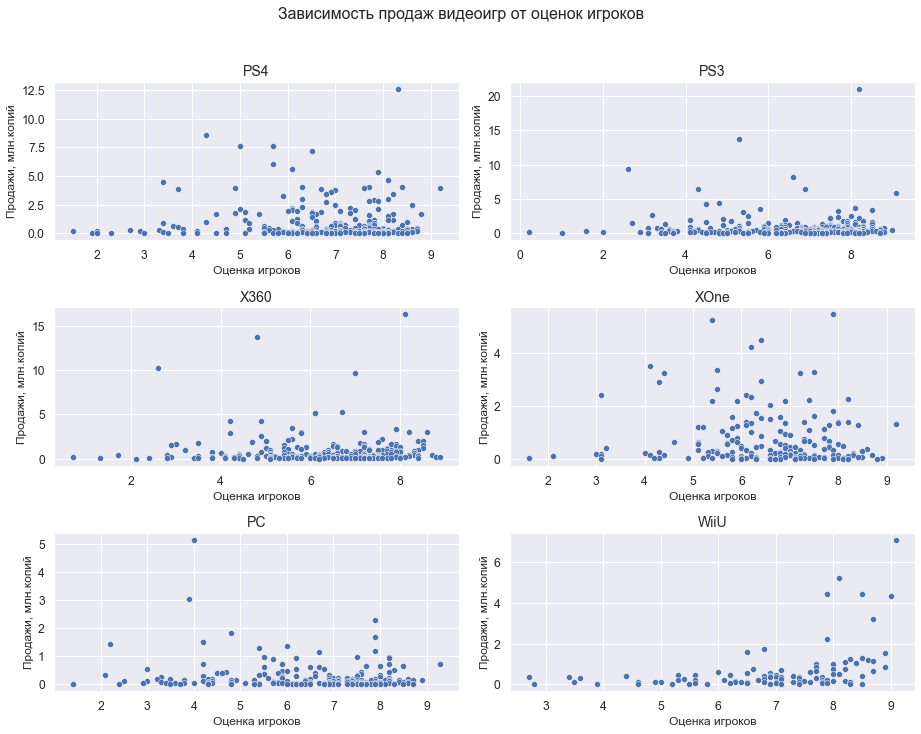

In [24]:
platforms = ['PS4', 'PS3', 'X360', 'XOne', 'PC', 'WiiU']

fig, axs = plt.subplots(3, 2, figsize=(13, 10))
fig.suptitle('Зависимость продаж видеоигр от оценок игроков', size=16, y=1.02)

for platform, ax in zip(platforms, np.ravel(axs)):
    sns.scatterplot(
        data=games_new.query('user_score > 0 and platform == @platform'), x='user_score', y='total_sales', ax=ax)
    ax.set_ylabel('Продажи, млн.копий', fontsize = 12)
    ax.set_xlabel('Оценка игроков', fontsize = 12)
    ax.set_title(platform, fontsize = 14)
plt.tight_layout()

In [25]:
for platform in platforms:
    print(platform)
    display(games_new.query('user_score > 0 and platform == @platform')[['user_score', 'total_sales']].corr())

PS4


,user_score,total_sales
user_score,1.000000,-0.031957
total_sales,-0.031957,1.000000


PS3


,user_score,total_sales
user_score,1.000000,-0.005144
total_sales,-0.005144,1.000000


X360


,user_score,total_sales
user_score,1.000000,0.006164
total_sales,0.006164,1.000000


XOne


,user_score,total_sales
user_score,1.000000,-0.068925
total_sales,-0.068925,1.000000


PC


,user_score,total_sales
user_score,1.000000,-0.121867
total_sales,-0.121867,1.000000


WiiU


,user_score,total_sales
user_score,1.000000,0.400219
total_sales,0.400219,1.000000


**Выводы**

* По матрицам корреляций заметно, что общие продажи игр достаточно слабо зависят от оценок критиков (особенно слабо зависят на платформах PC, PS3 и WiiU) и практически не зависят от оценок игроков (на всех платформах очень малая отрицательная корреляция (от -0.005 до -0.12), кроме платформы WiiU, там она положительная и равна 0.4), средние коэффициенты корреляции для оценок критиков и игроков равны 0.3 и 0.006 соответственно. На диаграммах распределения этот вывод подтверждается. 

### Распределение игр по жанрам

In [26]:
games_new_genres = (games_new.groupby('genre', as_index=False)['total_sales'].agg(['sum', 'count'])
                    .rename(columns={'sum':'total_sales', 'count':'games_cnt'}).sort_values(by='total_sales', ascending=False))

games_new_genres['avg_sales'] = round(games_new_genres['total_sales'] / games_new_genres['games_cnt'], 2)

In [27]:
games_new_genres

,total_sales,games_cnt,avg_sales
genre,,,
Action,373.72,652,0.57
Shooter,302.26,229,1.32
Sports,172.11,223,0.77
Role-Playing,89.56,176,0.51
Misc,70.38,117,0.60
Racing,51.01,105,0.49
Platform,38.94,56,0.70
Fighting,33.46,82,0.41
Adventure,19.61,122,0.16


Построим диаграммы размаха продаж игр для разных жанров

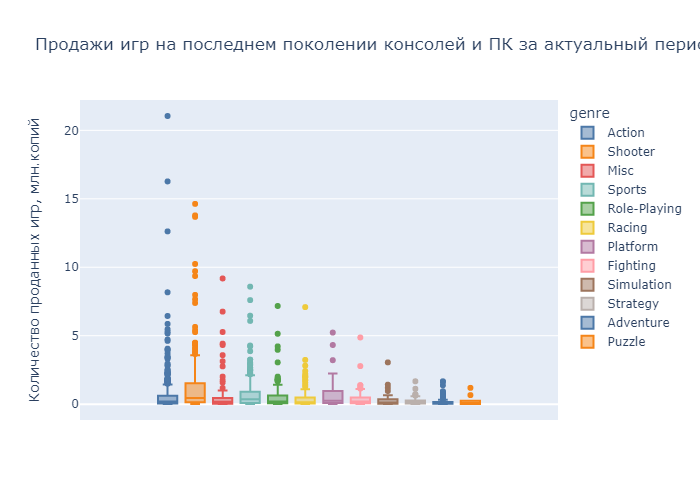

In [28]:
fig = px.box(games_new, y='total_sales', color = 'genre', 
             title="Продажи игр на последнем поколении консолей и ПК за актуальный период",
             color_discrete_sequence=px.colors.qualitative.T10)

fig.update_yaxes(title_text='Количество проданных игр, млн.копий')


fig.show("png")

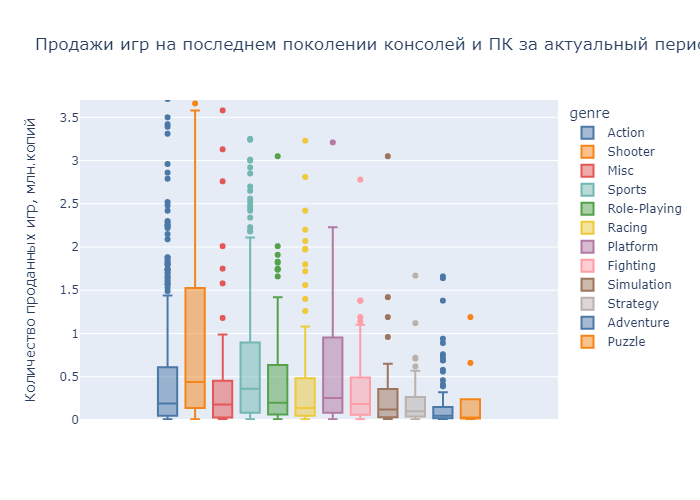

In [29]:
fig = px.box(games_new, y='total_sales', color = 'genre', 
             title="Продажи игр на последнем поколении консолей и ПК за актуальный период",
             color_discrete_sequence=px.colors.qualitative.T10)

fig.update_yaxes(title_text='Количество проданных игр, млн.копий', range=[0, 3.7], row=1, col=1)


fig.show("png")

**Выводы**

* Больше всего было продано игр жанров Action (373 млн.), Shooter (302 млн.) и Sports (172 млн.)
* Если говорить про самые популярные жанры на разных платформах, то топ 3 жанра на двух поколениях консолей XBOX и PS это жанры Action, Shooter  и Sports, на PC топ 3 жанра это те же Shooter, Action и добавляется RPG. На консолях от Nintendo самые популярные жанры  - Action, Misc и Platform (только на WiiU) 
* Если смотреть на метрику средних продаж одной игры (avg_sales), то наиболее прибыльными жанрами являются так же Shooter (1.32 млн.копий на одну игру), Sports (0.77 млн.) и Platform (0.7 млн.). Так же данный вывод подтверждает диаграмма размаха - медианные продажи лучше всего у жанров Shooter (0.44 млн.копий), Sports (0.36 млн.копий), Platform (0.26 млн.копий).
* Меньше всего выходило игр жанров Puzzle (всего 9), Strategy (49) и Simulation (55), они так же продались наименьшим тиражом из всех жанров.

## Портреты пользователей разных регионов

### Самые популярные платформы

Посмотрим самые популярные платформы с помощью группированной таблички и визуализаций

In [30]:
games_platform = (games_new.groupby('platform', as_index=False)[['na_sales', 'eu_sales','jp_sales']].agg('sum'))

games_platform_na = games_platform[['platform','na_sales']]
games_platform_na.loc[games_platform_na['na_sales'] < 38, 'platform'] = 'Other_platform' 
games_platform_na = games_platform_na.groupby('platform', as_index=False)['na_sales'].agg('sum')

games_platform_eu = games_platform[['platform','eu_sales']]
games_platform_eu.loc[games_platform_eu['eu_sales'] < 37, 'platform'] = 'Other_platform' 
games_platform_eu = games_platform_eu.groupby('platform', as_index=False)['eu_sales'].agg('sum')

games_platform_jp = games_platform[['platform','jp_sales']]
games_platform_jp.loc[games_platform_jp['jp_sales'] < 1, 'platform'] = 'Other_platform' 
games_platform_jp = games_platform_jp.groupby('platform', as_index=False)['jp_sales'].agg('sum')

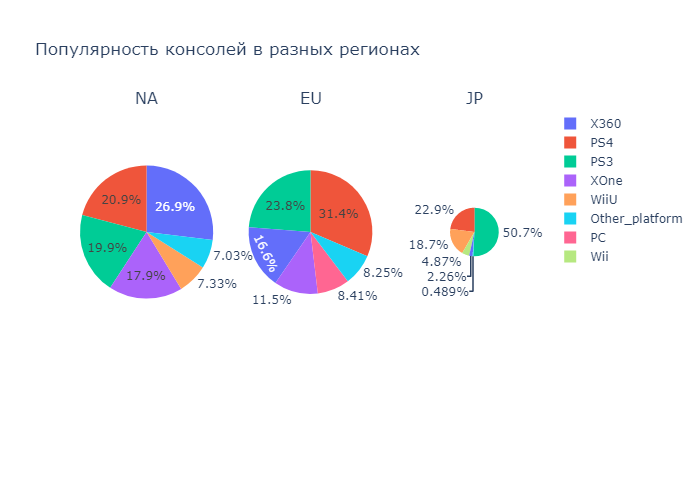

In [31]:
fig = make_subplots(1, 3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['NA', 'EU', 'JP'])

fig.add_trace(go.Pie(labels=games_platform_na['platform'], values=games_platform_na['na_sales'], 
                     name="NA", scalegroup='one'), 1, 1)
fig.add_trace(go.Pie(labels=games_platform_eu['platform'], values=games_platform_eu['eu_sales'], 
                     name="EU", scalegroup='one'), 1, 2)
fig.add_trace(go.Pie(labels=games_platform_jp['platform'], values=games_platform_jp['jp_sales'], 
                     name="JP", scalegroup='one'), 1, 3)

fig.update_layout(title_text='Популярность консолей в разных регионах')
fig.show("png")

**Выводы**

* Самые популярные платформы для разных регионов:
    * NA - X360 (140.05 млн.копий), PS4 (108.7 млн.копий), PS3 (103 млн.копий), XOne (93 млн.копий) и WiiU (38 млн.копий)
    * EU - PS4 (141.1 млн.копий), PS3 (106.9 млн.копий), X360 (74.5 млн.копий), XOne (51.6 млн.копий) и PC (38 млн.копий)
    * JP - PS3 (35.3 млн.копий), PS4 (16 млн.копий), WiiU (13 млн.копий), X360 (1.6 млн.копий), XOne (0.3 млн.копий) 
* Таким образом, за актуальный период в Северной Америке наиболее популярна были консоли X360 и PS4, в Европе PS4 И PS3, а в Японии PS3 и PS4. Стоит так же заметить, что в Япониина третьем месте по продажам игр идёт WiiU (в других регионах она на последнем месте), а игры на консоли Microsoft в этом регионе продаются довольно слабо.

### Самые популярные жанры 

Посмотрим самые популярные жанры с помощью группированной таблицы и визуализаций

In [32]:
games_genre = (games_new.groupby('genre', as_index=False)[['na_sales', 'eu_sales','jp_sales']].agg('sum'))

games_genre_na = games_genre[['genre','na_sales']]
games_genre_na.loc[games_genre_na['na_sales'] < 35, 'genre'] = 'Other_genre' 
games_genre_na = games_genre_na.groupby('genre', as_index=False)['na_sales'].agg('sum')

games_genre_eu = games_genre[['genre','eu_sales']]
games_genre_eu.loc[games_genre_eu['eu_sales'] < 26, 'genre'] = 'Other_genre' 
games_genre_eu = games_genre_eu.groupby('genre', as_index=False)['eu_sales'].agg('sum')

games_genre_jp = games_genre[['genre','jp_sales']]
games_genre_jp.loc[games_genre_jp['jp_sales'] < 4.6, 'genre'] = 'Other_genre' 
games_genre_jp = games_genre_jp.groupby('genre', as_index=False)['jp_sales'].agg('sum')

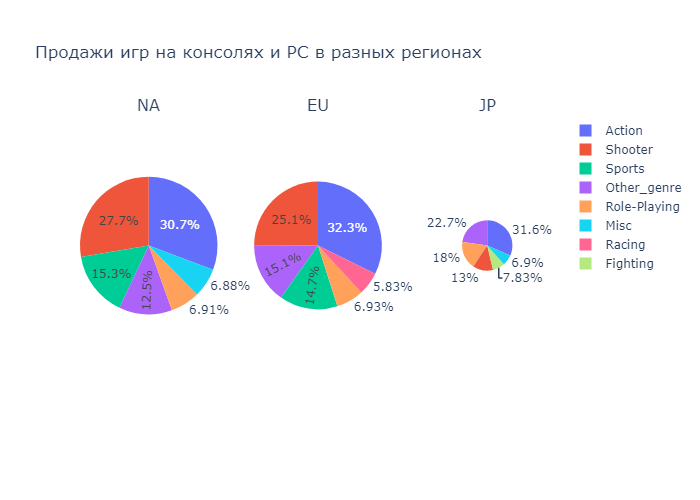

In [33]:
fig = make_subplots(1, 3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['NA', 'EU', 'JP'])

fig.add_trace(go.Pie(labels=games_genre_na['genre'], values=games_genre_na['na_sales'], 
                     name="NA", scalegroup='one'), 1, 1)
fig.add_trace(go.Pie(labels=games_genre_eu['genre'], values=games_genre_eu['eu_sales'], 
                     name="EU", scalegroup='one'), 1, 2)
fig.add_trace(go.Pie(labels=games_genre_jp['genre'], values=games_genre_jp['jp_sales'], 
                     name="JP", scalegroup='one'), 1, 3)

fig.update_layout(title_text='Продажи игр на консолях и PC в разных регионах')
fig.show("png")

In [34]:
fig = go.Figure(data=[go.Pie(labels=games_genre_na['genre'], values=games_genre_na['na_sales'])])

**Выводы**

* Самые популярные жанры для разных регионов:
    * NA - Action (159.8 млн.копий), Shooter (143.8 млн.копий), Sports (79.7 млн.копий), RPG (35.9), Misc (35.8)
    * EU - Action (145 млн.копий), Shooter (112.6 млн.копий), Sports (66.2 млн.копий), RPG (31.1 млн.копий) и Racing (26.2 млн.копий)
    * JP - Action (21.9 млн.копий), RPG (12.5 млн.копий), Shooter (9.1 млн.копий), Fighting (5.5 млн.копий) и Misc (4.8 млн.копий)

* Таким образом жанры Action, Shooter и RPG крайне популярны во всех регионах, в Северной Америке и Европе так же популярен жанр Sports, а в Японии Fighting.

### Влияние рейтинга ESRB на продажи в отдельном регионе

Посмотрим влияние рейтинга ESRB на продажи в каждом из регионов

In [35]:
esrb_na = games_new.groupby('rating', as_index=False)['na_sales'].agg(['sum', 'count'])
esrb_na['avg_sales_na'] = round(esrb_na['sum'] / esrb_na['count'],2)

esrb_eu = games_new.groupby('rating', as_index=False)['eu_sales'].agg(['sum', 'count'])
esrb_eu['avg_sales_eu'] = round(esrb_eu['sum'] / esrb_eu['count'],2)

esrb_jp = games_new.groupby('rating', as_index=False)['jp_sales'].agg(['sum', 'count'])
esrb_jp['avg_sales_jp'] = round(esrb_jp['sum'] / esrb_jp['count'],2)

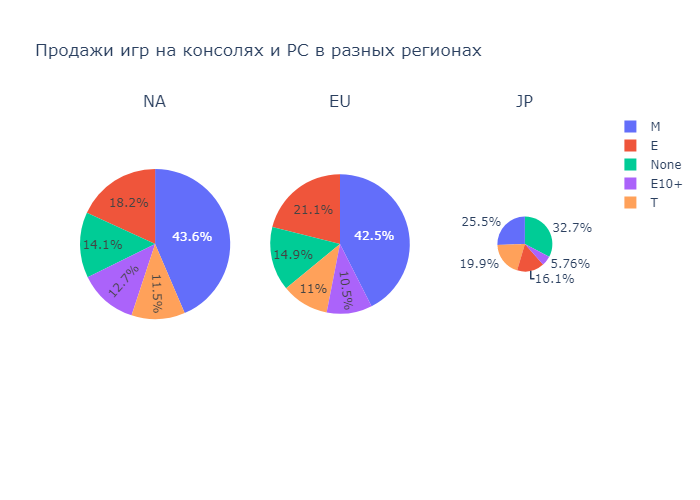

In [36]:
fig = make_subplots(1, 3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['NA', 'EU', 'JP'])

fig.add_trace(go.Pie(labels=esrb_na.index, values=esrb_na['sum'], 
                     name="NA", scalegroup='one'), 1, 1)
fig.add_trace(go.Pie(labels=esrb_eu.index, values=esrb_eu['sum'], 
                     name="EU", scalegroup='one'), 1, 2)
fig.add_trace(go.Pie(labels=esrb_jp.index, values=esrb_jp['sum'], 
                     name="JP", scalegroup='one'), 1, 3)

fig.update_layout(title_text='Продажи игр на консолях и PC в разных регионах')
fig.show("png")

In [37]:
display(esrb_na.sort_values(by='avg_sales_na', ascending=False))
display(esrb_eu.sort_values(by='avg_sales_eu', ascending=False))
display(esrb_jp.sort_values(by='avg_sales_jp', ascending=False))

,sum,count,avg_sales_na
rating,,,
M,226.50,457,0.50
E,94.38,306,0.31
E10+,65.79,225,0.29
T,59.85,321,0.19
None,73.44,566,0.13


,sum,count,avg_sales_eu
rating,,,
M,190.93,457,0.42
E,94.71,306,0.31
E10+,47.26,225,0.21
T,49.25,321,0.15
None,66.72,566,0.12


,sum,count,avg_sales_jp
rating,,,
E,11.17,306,0.04
M,17.76,457,0.04
None,22.76,566,0.04
T,13.86,321,0.04
E10+,4.01,225,0.02


**Выводы**

* Влияние возрастного рейтинга на продажи игр в разных регионах:
    * NA - больше всего было продано игр с рейтингом М - 226 млн.копий (они и продаются лучше других, если смотреть на метрику avg_sales (0.50 млн.копий на игру)), затем идут игры с рейтингом E - 94 млн.копий, avg_sales равен 0.31 млн.копий на игру, на третьем же месте игры с необозначенным рейтингом ESRB -73 млн.копий (avg_sales равен 0.13), то есть игры не были оценены комиссией ESRB. Возможно к данной категории относятся малоизвестные игры, до которых у комиссии не дошли руки.
    * EU - больше всего было продано игр так же с рейтингом М - 191 млн.копий, avg_sales равен 0.42 млн.копий на игру, затем идут игры с рейтингом E - 95 млн.копий и avg_sales равен 0.31 млн.копий на игру, на третьем месте игры с необозначенным рейтингом - 67 млн.копий и метрикой avg_sales в 0.12 млн.копий на игру.
    *JP - игры с отсутствующим рейтингом ESRB продались наибольшим тиражом в 23 млн.копий (скорее всего так же малоизвестные и небольшие игры, которые комиссия не успела оценить). Avg_sales у игр без рейтинга ESRB равен 0.04 млн.копий на игру, так же как и у игр с рейтингом E,M и T. На втором месте по продажам в этом регионе идут игры с рейтингом M - 18 млн.копий, на третьем игры с рейтингом Т - 14 млн.копий. 
* Таким образом, можно спокойно делать ставку на игры с рейтингом М или Е, они стабильно хорошо продаются во всех регионах.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC не отличаются

**Нулевая гипотеза** - Средние пользовательские рейтинги платформ Xbox One и PC не отличаются

**Альтернативная гипотеза** - Средние пользовательские рейтинги платформ Xbox One и PC различаются

**Критический уровень значимости (альфа)** - 0.05

Создадим группированную табличку, чтобы посмотреть пользовательские оценки на платформах PC и XOne

In [38]:
games_new.query('platform == ["PC", "XOne"] and user_score > 0').groupby('platform')['user_score'].agg('mean')

platform
PC      6.428641
XOne    6.521429
Name: user_score, dtype: float64

**Выводы**

Можем заметить, что средний балл на этих платформах различается очень незначительно (всего на 0.1 пункта). Теперь посмотрим, различаются ли они статистически. Для проверки гипотезы будем использовать функцию `stats.ttest_ind`, так как мы рассматриваем среднее двух независимых совокупностей (оценки пользователей разных платформ).

In [39]:
xb_rating = games_new.query('platform == "XOne" and user_score > 0')['user_score']
pc_rating = games_new.query('platform == "PC" and user_score > 0')['user_score']

alpha = .05

results = st.ttest_ind(xb_rating, pc_rating)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


**Выводы**

Мы не отвергаем нулевую гипотезу о равенстве средней пользовательской оценки на платформах PC и XOne, так как p-value выше критического уровеня значимости (который мы задали равным 0.05).

Таким образом, средняя оценка пользователей на двух платформах не отличается.

### Средние пользовательские рейтинги жанров Action и Sports не отличаются

**Нулевая гипотеза** - Средние пользовательские рейтинги жанров Action и Sports не отличаются

**Альтернативная гипотеза** - Средние пользовательские рейтинги жанров Action и Sports различаются

**Критический уровень значимости (альфа)** - 0.05

Аналогично с предыдущей гипотезой создадим сводную таблицу для просмотра рейтинга пользователей по двум жанрам

In [40]:
games_new.query('genre == ["Action","Sports"] and user_score > 0').groupby('genre')['user_score'].agg('mean')

genre
Action    6.797209
Sports    5.424725
Name: user_score, dtype: float64

**Выводы**

Разница в оценках пользователей по жанрам Action и Sports различаются незначительно (1 пункт). Теперь посмотрим, различаются ли они статистически. Для проверки гипотезы так же будем использовать функцию `stats.ttest_ind`.

In [41]:
action_rating = games_new.query('genre == "Action" and user_score > 0')['user_score']
sports_rating = games_new.query('genre == "Sports" and user_score > 0')['user_score']

alpha = .05

results = st.ttest_ind(action_rating, sports_rating)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.6650272459558064e-24
Отвергаем нулевую гипотезу


**Выводы**

Мы отвергаем нулевую гипотезу о равенстве средней пользовательской оценки для жанров Sports и Action, так как p-value ниже критического уровеня значимости (который мы задали равным 0.05).

Таким образом, подтвердилась альтернативная гипотеза о неравенстве пользовательских оценок для жанров Action и Sports.

## Выводы и рекомендации по проекту

**Выводы**

* Пик по количеству выпущенных игры был в 2008 году 
* Playstation обгоняет другие консоли и PC по продажам, жизненный цикл консолей составляет от 4 до 8 лет
* Если говорить о новом поколении консолей (с 2012 года), то больше всего игр было продано на консоли PS4 (314 млн.копий) и PS3 (289 млн.копий), затем идут X360 (237 млн.копий) и XOne (155 млн.копий).
* По матрице корреляций заметно, что общие продажи игр достаточно слабо зависят от оценок критиков и не зависят от оценок игроков, усредненные коэффициенты корреляции равны 0.3 и 0.006 соответственно.
* В разрезе жанров видеоигр можно сказать, что больше всего было продано игр жанров Action (373 млн.), Shooter (302 млн.) и Sports (172 млн.). А если смотреть на метрику средних продаж одной игры (avg_sales), то наиболее прибыльными жанрами являются так же Shooter (1.32 млн.копий на одну игру), Sports (0.77 млн.) и Platform (0.7 млн.). 
* Если говорить про самые популярные жанры на разных платформах, то топ 3 жанра на двух поколениях консолей XBOX и PS это жанры Action, Shooter и Sports, на PC топ 3 жанра это те же Shooter, Action и добавляется RPG. На консолях от Nintendo самые популярные жанры - Action, Misc и Platform (только на WiiU)
* Наиболее прибыльные игры по рейтингу ESRB - игры с рейтингом M и E.
* Самые популярные платформы на примере регионa NA (где было больше всего продаж на новом поколении консолей): 
    * NA - X360 (140.05 млн.копий)
    * PS4 (108.7 млн.копий)
    * PS3 (103 млн.копий)
    * XOne (93 млн.копий) 
    * WiiU (38 млн.копий)
* Самые популярные жанры игр так же на примере региона NA:
    * NA - Action (159.8 млн.копий)
    * Shooter (143.8 млн.копий)
    * Sports (79.7 млн.копий)
    * RPG (35.9 млн.копий)
    * Misc (35.8 млн.копий)
* Так же мы проверили две гипотезы и выяснили, что:
    * Средняя оценка пользователей на платформах XBOX One и PC не отличается
    * Пользовательские оценки для жанров Action и Sports различаются.

**Рекомендации**

Возвращаясь к вопросу, которому был посвящён данный проект - определить потенциально популярный продукт и спланировать рекламные компании. На данный вопрос можно уверенно ответить, что самой прибыльной платформой для 2017 года будет PS4, на втором месте идёт XBOX One. Продажи игр на консоли прошлого поколения и PC значительно ниже, чем на PS4 и XOne (если смотреть продажи за 15-16 года). Самые популярные жанры для консолей PS4 и XOne - Action, Shooter, Sports и RPG, а самые прибыльные -  Shooter (1.32 млн.копий на одну игру), Sports (0.77 млн.копий на одну игру) и Platform (0.7 млн.копий на одну игру). Наиболее прибыльные регионы - Северная Америка и Европа. А самые прибыльные рейтинги - М и Е.